In [26]:

import cv2 as cv  
import numpy as np  
import matplotlib.pyplot as plt  

class Image_processing:
    def __init__(self, image_path, expected_grid=(8, 12)):
        """
        Initialises the Image_processing class with the image path and expected grid dimensions.
        
        Args:
            image_path (str): Path to the image file.
            expected_grid (tuple): Expected grid dimensions (rows, columns) for the well plate.
        """
        self.image_path = image_path  
        self.expected_grid = expected_grid  
        self.image = cv.imread(image_path)  
        # Placeholder for detected circles
        self.best_circles = None  

    def filter_circular_contours(self, contours):
        """
        Filters contours to keep only those that are  circular.
        
        Args:
            contours (list): List of contours detected in the image.
        
        Returns:
            list: List of radii of contours that are  circular.
        """
        # List to store radii of valid circular contours
        valid_circle = []  
        for cont in contours:
            # Calculate the perimeter of the contour
            perimeter = cv.arcLength(cont, True)  

            # Calculate the area of the contour
            area = cv.contourArea(cont)  
            # Avoid division by zero
            if perimeter == 0:
                continue  
            circularity = 4 * np.pi * (area / (perimeter ** 2))  
            if 0.8 < circularity < 1.2:  
                _, radius = cv.minEnclosingCircle(cont)  
                valid_circle.append(radius)  
        return valid_circle
    
    def enforce_grid_pattern(self, circles):
        """
        Enforces a grid pattern on the detected circles to align them with the expected well plate layout.
        
        Args:
            circles (np.ndarray): Detected circles, represented as (x, y and radius).
        
        Returns:
            np.ndarray: Array of circles aligned in a grid pattern.
        """
        # Check circles are valid
        if circles is None or len(circles[0]) < 2:
            return None  
        
        # Extract (x, y, radius) positions of the circles. Selects all circles and their first 3 values (x, y, radius)
        circle_positions = circles[0, :, :3]  
        
        # Sort circles by Y-coordinate (row-wise sorting).
        #Circles are processed from top to bottom
        sorted_by_y = sorted(circle_positions, key=lambda p: p[1])
        
        # Group circles into rows based on distance to Y-coordinates.
        rows = []
        # Differences in y-coordinates. 
        y_differences = np.diff([p[1] for p in sorted_by_y])
        # Median difference between circles in Y-direction
        median_diff = np.median(y_differences)
        #Threshold to organise circles into rows
        row_threshold = median_diff + np.std(y_differences)
        # Initialise first row ith first circle.
        current_row = [sorted_by_y[0]]

        # Iterate through the remaining circles to organise them into rows
        for i in range(1, len(sorted_by_y)):
            # Check if the current circle is close enough in Y-coordinate to be part of the current row
            if abs(sorted_by_y[i][1] - current_row[-1][1]) < row_threshold:
                current_row.append(sorted_by_y[i]) 

            # If not, finish  current row by sorting it by X-coordinate.
            else:
                rows.append(sorted(current_row, key=lambda p: p[0])) 
                current_row = [sorted_by_y[i]]  

        # Add the last row to the list of rows
        rows.append(sorted(current_row, key=lambda p: p[0]))  # Add the last row

        # Confirm numbers of circles
        corrected_rows = []
        for row in rows:
            if len(row) == 12:
                corrected_rows.append(row)
            # If the row has too many circles. Sort row by X-coord and keep the first correct
            #12 circles 
            elif len(row) > 12:
                sorted_row = sorted(row, key=lambda p: p[0])
                corrected_rows.append(sorted_row[:12])
            else:
                continue

        # Flatten corrected rows back into a single array
        sorted_circles = np.array([circle for row in corrected_rows for circle in row])

        # Limit to expected number of wells (8x12 = 96)
        if len(sorted_circles) > self.expected_grid[0] * self.expected_grid[1]:
            sorted_circles = sorted_circles[:self.expected_grid[0] * self.expected_grid[1]]

        return np.array([sorted_circles], dtype=np.float32)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y, r = int(circle[0]), int(circle[1]), int(circle[2])
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image and extracts RGB values.
        
        Returns:
            np.ndarray: Array of RGB values for each detected circle, or None if detection fails.
        """
        # Convert the image to grayscale
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        
        # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Apply median blur to reduce noise
        blurred = cv.medianBlur(gray, 5)
        
        # Detect edges using the Canny edge detector
        edges = cv.Canny(blurred, 50, 150)

        # Find contours in the edge-detected image
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None

        # Filter circular contours only
        valid_circle = self.filter_circular_contours(contours)

        if len(valid_circle) < 5:
            print("Not enough valid circles detected from contours.")
            return None

        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using Hough Circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If circles are detected, enforce grid pattern to remove outliers
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                self.best_circles = best_circles
                
                # Return the array of RGB values
                return rgb_values
    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.
        
        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles[0, :]):
                # Ensure centre and radius are integers
                x, y, r = int(circle[0]), int(circle[1]), int(circle[2])  # Convert to integers
                center = (x, y)  
                radius = r  
                # Draw green circle
                cv.circle(image, center, radius, (0, 255, 0), 2)  
                # Draw red bullseye
                cv.circle(image, center, 5, (0, 0, 255), -1)  
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Label the circle
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

RGB Values:
[[119  80   2]
 [128  89   8]
 [125  85   2]
 [123  82   0]
 [125  88   0]
 [117  79   0]
 [122  85   1]
 [121  83   0]
 [125  88   0]
 [126  89   1]
 [128  89   1]
 [124  86   5]
 [119  81   0]
 [128  86   4]
 [131  91   4]
 [131  93   3]
 [131  93   4]
 [131  91   3]
 [126  85   2]
 [133  91   3]
 [130  90   1]
 [129  92   7]
 [128  87   3]
 [125  83   2]
 [127  86   3]
 [136  97   1]
 [132  93   0]
 [144 103   5]
 [ 40   6   6]
 [134  95   2]
 [130  93   0]
 [ 47  11  12]
 [132  89   0]
 [127  89   1]
 [135  96   2]
 [131  93   3]
 [134  93   1]
 [137  93   1]
 [137  94   0]
 [138  99   4]
 [141  98   3]
 [137  99   2]
 [131  90   1]
 [143 101   5]
 [135  93   0]
 [134  96   2]
 [142  98   6]
 [127  88   3]
 [136  95   2]
 [149 106  12]
 [146 103   3]
 [145 103   3]
 [141  98   3]
 [138  97   3]
 [138  95   4]
 [135  95   0]
 [136  93   1]
 [133  93   8]
 [136  97   0]
 [136  93   4]
 [143 100   0]
 [166 127  22]
 [167 124  32]
 [ 40   6   7]
 [144  99   0]
 [139  98   1

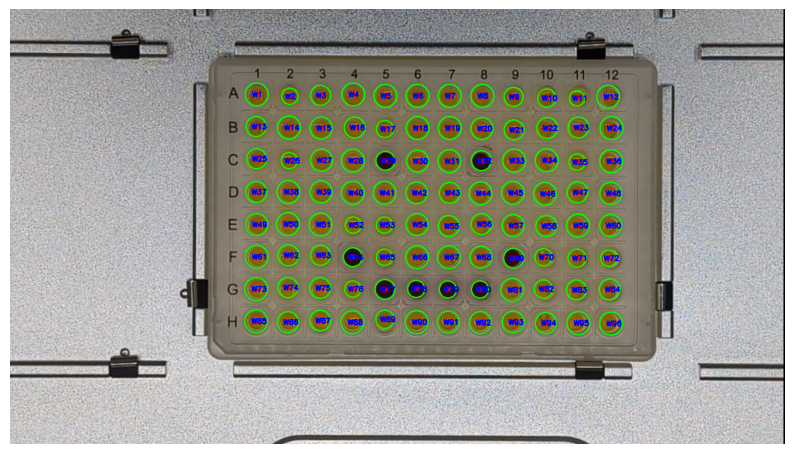

In [27]:
# Example use demo
demo = Image_processing('demo.jpg', expected_grid=(8, 12))
rgb_values = demo.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
demo.plot_picture()

RGB Values:
[[115 103  66]
 [106  96  62]
 [106  99  60]
 [103  95  38]
 [106  96  47]
 [105  98  59]
 [112 102  73]
 [112 100  61]
 [116 110  76]
 [114 112 100]
 [119 112  85]
 [118 108  88]
 [110 101  67]
 [116 104  55]
 [111  97  28]
 [112 100  45]
 [112  98  41]
 [108 102  52]
 [110 101  41]
 [115 107  57]
 [116 107  60]
 [122 116  81]
 [117 105  55]
 [121 112  81]
 [106 100  56]
 [112 102  46]
 [112 104  37]
 [116 110  31]
 [ 94  50  55]
 [116 108  51]
 [115 104  51]
 [117  82  85]
 [125 117  78]
 [122 116  76]
 [126 120  87]
 [120 113  79]
 [117 108  78]
 [117 104  31]
 [115 107  37]
 [124 112  46]
 [117 104  38]
 [115 108  44]
 [120 109  54]
 [122 113  63]
 [119 112  56]
 [121 114  68]
 [128 120  92]
 [123 118  89]
 [113 105  61]
 [127 112  36]
 [123 106  34]
 [123 110  35]
 [123 111  35]
 [116 106  48]
 [120 111  46]
 [118 110  55]
 [121 111  59]
 [122 120 108]
 [130 123  89]
 [135 126 100]
 [122 116  75]
 [131 112  31]
 [115 105  37]
 [ 88  30  36]
 [129 115  39]
 [120 107  38

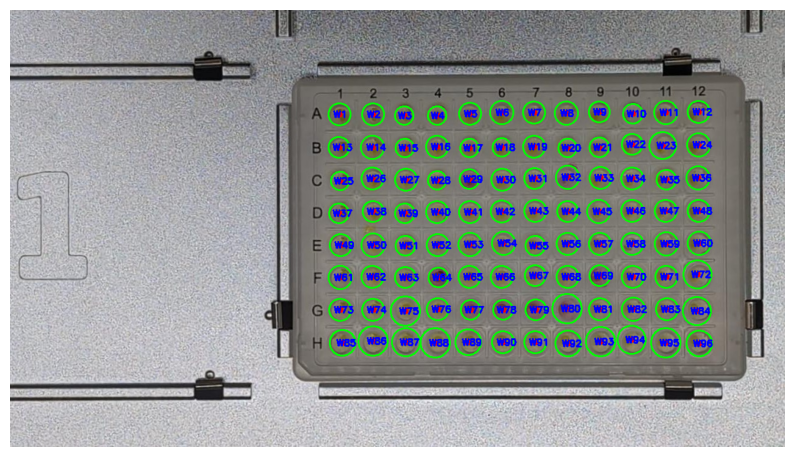

In [28]:
# Example use demo
demo1 = Image_processing('demo1.jpg', expected_grid=(8, 12))
rgb_values = demo1.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
demo1.plot_picture()

RGB Values:
[[113  99  60]
 [105  96  61]
 [ 98  96  56]
 [ 99  92  31]
 [105  95  53]
 [104  95  54]
 [108 103  63]
 [110 101  64]
 [115 107  69]
 [112 109 101]
 [119 113  92]
 [115 109  88]
 [111  99  63]
 [113 101  53]
 [112  99  39]
 [111  97  47]
 [107 100  54]
 [110  97  47]
 [111 100  47]
 [117 105  71]
 [118 107  79]
 [117 111  76]
 [123 116  85]
 [118 109  80]
 [113 104  69]
 [115 104  38]
 [113 104  43]
 [122 108  43]
 [ 90  46  53]
 [116 106  58]
 [112 104  47]
 [ 99  76  76]
 [118 112  70]
 [122 115  82]
 [117 109  61]
 [124 116  88]
 [109 101  57]
 [116 102  32]
 [122 108  60]
 [119 109  46]
 [119 100  34]
 [114 103  42]
 [119 105  46]
 [119 108  48]
 [123 110  63]
 [129 120  89]
 [122 114  79]
 [113 102  60]
 [113 105  55]
 [118 109  39]
 [121 112  35]
 [124 108  40]
 [116 107  43]
 [116 104  41]
 [122 110  49]
 [121 107  42]
 [124 111  70]
 [123 115 107]
 [120 110  65]
 [133 124  95]
 [122 110  73]
 [128 111  26]
 [121 103  46]
 [ 87  29  36]
 [123 107  28]
 [115 104  43

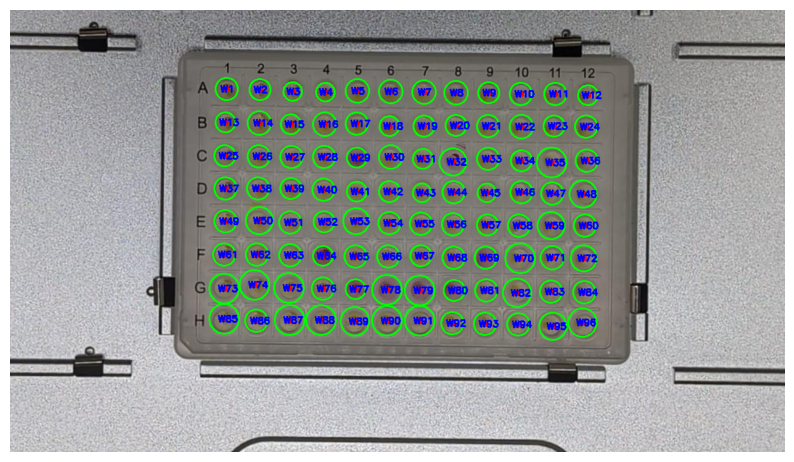

In [29]:
# Example use demo
demo2 = Image_processing('demo2.jpg', expected_grid=(8, 12))
rgb_values = demo2.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
demo2.plot_picture()

RGB Values:
[[121  83   2]
 [124  87   5]
 [122  83   4]
 [128  87   2]
 [128  88   2]
 [118  77   0]
 [124  86   7]
 [120  83   0]
 [126  89   3]
 [138 101  15]
 [126  87   0]
 [120  84   6]
 [131  90   5]
 [128  87   2]
 [128  84   1]
 [134  91   3]
 [129  92   2]
 [132  93   2]
 [131  91   3]
 [129  92   3]
 [128  92   1]
 [124  87   0]
 [128  92   1]
 [126  85   0]
 [126  88   1]
 [141 100   5]
 [132  91   1]
 [139  99   1]
 [ 63  23  24]
 [135  93   4]
 [130  91   1]
 [ 75  38  40]
 [134  91   0]
 [128  92   0]
 [131  90   2]
 [130  94   2]
 [134  91   1]
 [136  96   0]
 [138  95   0]
 [135  96   4]
 [137  95   3]
 [137  97   2]
 [134  96   0]
 [137  99   3]
 [138  95   3]
 [130  92   1]
 [136  95   4]
 [128  92   0]
 [135  98   1]
 [139  95   1]
 [147 101  12]
 [149 106   3]
 [137  98   5]
 [141 101   5]
 [137  95   0]
 [136  97   1]
 [135  91   2]
 [161 122  25]
 [132  93   0]
 [131  91   0]
 [148 105   4]
 [146 101   1]
 [144 102   2]
 [ 42   6  10]
 [146  99   7]
 [137  97   1

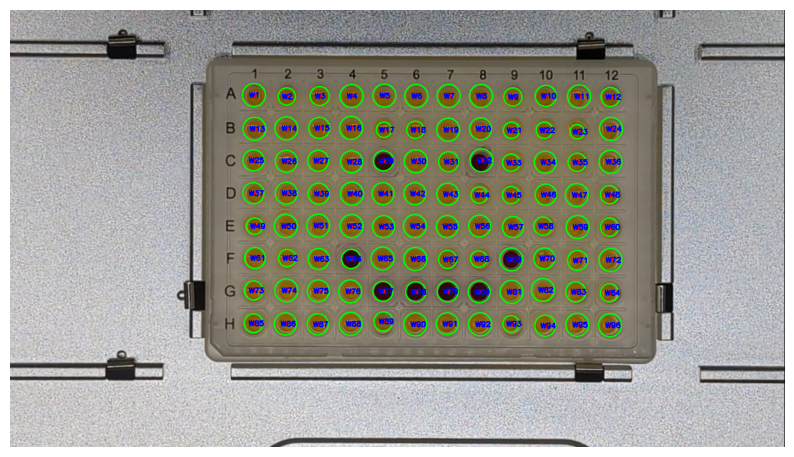

In [30]:
# Example use demo
demo3 = Image_processing('demo3.jpg', expected_grid=(8, 12))
rgb_values = demo3.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
demo3.plot_picture()

In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class previous_Image_processing:
    def __init__(self, image_path, expected_grid=(8,12)):
        self.image_path = image_path
        self.expected_grid = expected_grid
        self.image = cv.imread(image_path)
        self.labelled_rgb_values = None  # Store labelled RGB values here
        self.best_circles = None

    def enforce_grid_pattern(self, circles):
        """
        Forces a grid structure on detected circles by sorting and filtering.
        
        Args:
            circles (np.ndarray): Detected circles from HoughCircles.
        
        Returns:
            np.ndarray: Filtered circles arranged in a grid-like pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None
        
        # Extract (x, y) positions only.
        circle_positions = circles[0, :, :2]
        
        # Sort circles by their y-coordinate (rows) and then by x-coordinate (columns)
        sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
        sorted_circles = circles[0, sorted_indices]
        
        # Calculate the expected number of circles
        expected_num_circles = self.expected_grid[0] * self.expected_grid[1]
        
        # If more circles are detected than expected, keep only the first `expected_num_circles`
        if len(sorted_circles) > expected_num_circles:
            sorted_circles = sorted_circles[:expected_num_circles]
        
        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image, extracts RGB values, and prints labelled results.
        
        Returns:
            dict: Labelled RGB values for each detected well, or None if detection fails.
        """
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        gray = cv.equalizeHist(gray)
        blurred = cv.medianBlur(gray, 5)
        edges = cv.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None
        
        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using hough circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If it works, use enforce grid to remove outliers --> align to 96 well plate
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                circle_positions = best_circles[0, :, :2]
                
                # Sort wells by their positions (top-left to bottom-right order)
                sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
                sorted_circles = best_circles[0, sorted_indices]
                
                # Assign well labels
                well_labels = [f"W{i + 1}" for i in range(self.expected_grid[0] * self.expected_grid[1])]
                self.labelled_rgb_values = dict(zip(well_labels, rgb_values[sorted_indices]))
                self.best_circles = sorted_circles

                for well, rgb in self.labelled_rgb_values.items():
                
                    return rgb_values[sorted_indices]

    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.

        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()


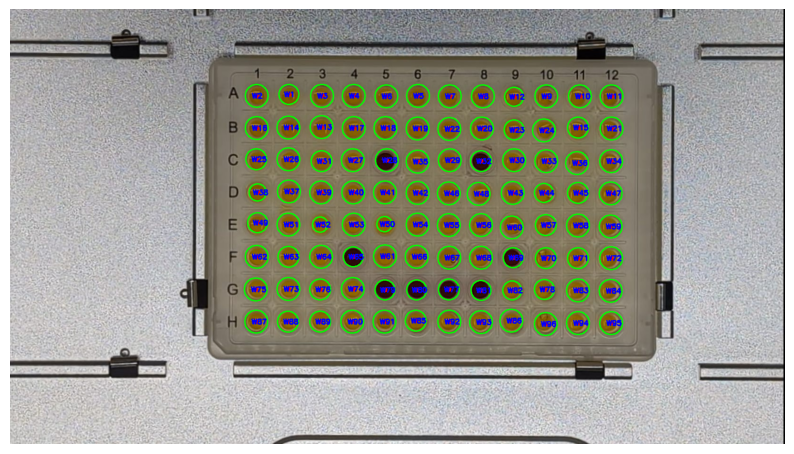

array([[125,  87,   7],
       [125,  87,   4],
       [125,  84,   3],
       [127,  87,   0],
       [117,  79,   0],
       [125,  88,   0],
       [121,  84,   2],
       [123,  85,   0],
       [126,  88,   4],
       [125,  88,   1],
       [119,  83,   0],
       [126,  89,   0],
       [124,  85,   2],
       [128,  87,   3],
       [130,  88,   3],
       [128,  88,   3],
       [133,  94,   2],
       [127,  89,   3],
       [131,  92,   3],
       [133,  91,   3],
       [128,  86,   3],
       [130,  89,   0],
       [130,  90,   1],
       [131,  89,   1],
       [127,  88,   1],
       [133,  93,   1],
       [144, 104,   7],
       [ 51,  16,  17],
       [132,  94,   3],
       [130,  87,   0],
       [135,  94,   1],
       [ 40,   4,   4],
       [129,  93,   2],
       [131,  93,   3],
       [134,  95,   1],
       [134,  96,   2],
       [143,  99,   9],
       [137,  94,   2],
       [140,  96,   1],
       [137,  98,   4],
       [140,  97,   2],
       [137,  99

In [32]:
old_demo = previous_Image_processing('demo.jpg', expected_grid=(8, 12))
rgb_values = old_demo.auto_hough_circle_detection()
old_demo.plot_picture()
rgb_values

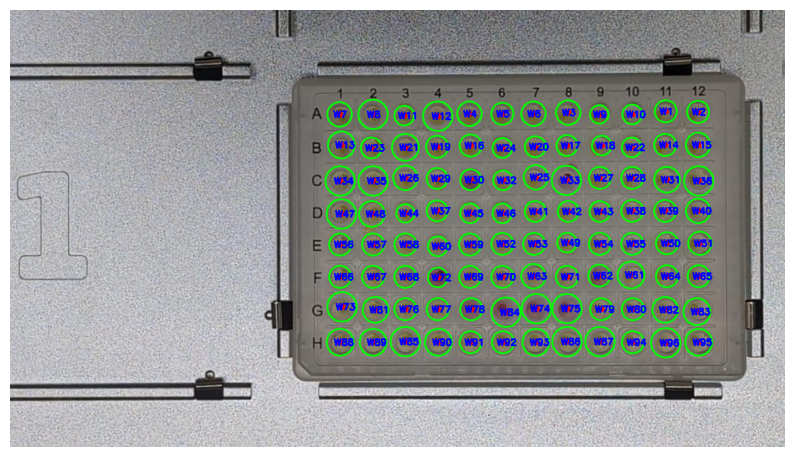

array([[120, 114,  88],
       [116, 106,  86],
       [115, 108,  76],
       [106,  96,  45],
       [105,  96,  50],
       [107,  98,  57],
       [115, 103,  66],
       [106,  96,  62],
       [106, 102,  56],
       [112, 110,  98],
       [106,  99,  60],
       [102,  92,  33],
       [116, 101,  51],
       [123, 115,  80],
       [120, 111,  77],
       [107, 101,  59],
       [115, 107,  67],
       [117, 113,  84],
       [112, 100,  45],
       [111, 102,  45],
       [111,  96,  31],
       [118, 108,  64],
       [118, 105,  58],
       [108,  99,  52],
       [119, 110,  68],
       [114, 104,  52],
       [123, 114,  73],
       [123, 118,  81],
       [114, 109,  46],
       [ 91,  44,  49],
       [125, 119,  89],
       [117, 107,  49],
       [112,  84,  84],
       [106, 100,  56],
       [116, 103,  30],
       [121, 115,  78],
       [121, 109,  50],
       [121, 114,  68],
       [124, 116,  86],
       [120, 115,  83],
       [120, 109,  51],
       [122, 113

In [33]:
old_demo1 = previous_Image_processing('demo1.jpg', expected_grid=(8, 12))
rgb_values = old_demo1.auto_hough_circle_detection()
old_demo1.plot_picture()
rgb_values

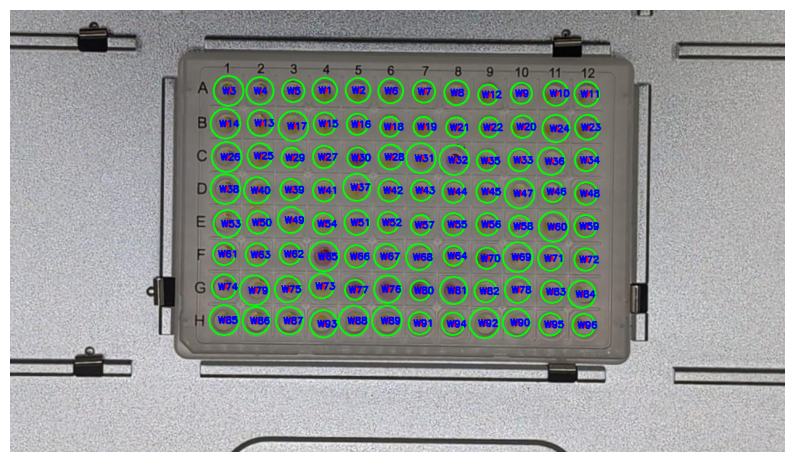

array([[104,  96,  50],
       [104,  96,  58],
       [100,  87,  42],
       [103,  95,  54],
       [ 99,  96,  61],
       [105,  97,  60],
       [110, 105,  68],
       [111, 102,  69],
       [114, 111, 102],
       [119, 113,  93],
       [115, 108,  86],
       [111,  99,  50],
       [109,  94,  45],
       [110,  98,  62],
       [111,  98,  52],
       [104,  97,  47],
       [106,  92,  18],
       [108,  96,  44],
       [110,  99,  40],
       [121, 114,  83],
       [115, 103,  62],
       [117, 107,  79],
       [119, 112,  86],
       [116, 113,  84],
       [110,  99,  34],
       [105,  94,  48],
       [122, 108,  43],
       [116, 106,  58],
       [113, 102,  37],
       [ 90,  47,  54],
       [115, 104,  44],
       [112,  85,  86],
       [122, 112,  73],
       [123, 114,  88],
       [117, 108,  52],
       [117, 109,  59],
       [118, 104,  58],
       [109, 101,  58],
       [119, 106,  48],
       [125, 109,  40],
       [119, 108,  42],
       [117, 106

In [34]:
old_demo2 = previous_Image_processing('demo2.jpg', expected_grid=(8, 12))
rgb_values = old_demo2.auto_hough_circle_detection()
old_demo2.plot_picture()
rgb_values

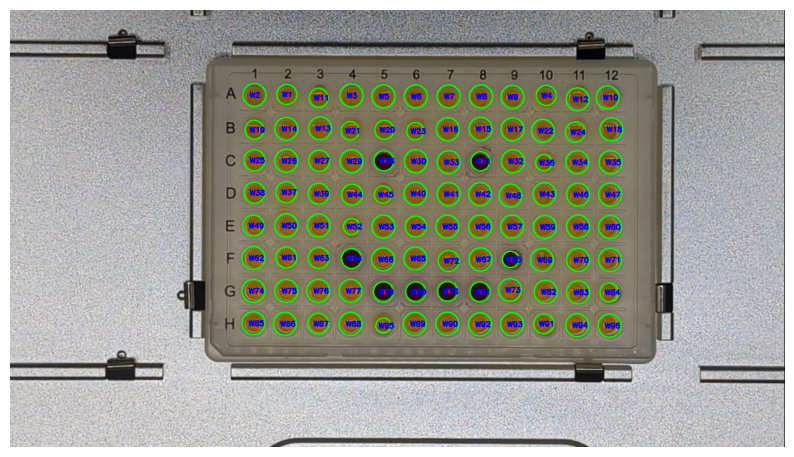

array([[125,  88,  12],
       [122,  83,   3],
       [127,  86,   2],
       [135,  98,  11],
       [130,  90,   2],
       [120,  79,   1],
       [120,  81,   2],
       [122,  85,   0],
       [126,  90,   3],
       [122,  86,   3],
       [123,  85,   2],
       [129,  88,   1],
       [129,  86,   2],
       [130,  88,   3],
       [129,  92,   3],
       [127,  87,   2],
       [126,  90,   2],
       [127,  86,   0],
       [129,  88,   1],
       [130,  93,   2],
       [133,  91,   1],
       [125,  88,   0],
       [130,  92,   1],
       [129,  92,   1],
       [128,  87,   1],
       [142, 100,   7],
       [132,  91,   0],
       [ 63,  23,  25],
       [139, 100,   2],
       [135,  93,   4],
       [ 55,  19,  20],
       [133,  93,   7],
       [132,  92,   0],
       [131,  90,   2],
       [130,  93,   2],
       [130,  95,   1],
       [151, 110,  12],
       [131,  91,   0],
       [138,  95,   0],
       [137,  97,   2],
       [135,  96,   1],
       [136,  97

In [35]:
old_demo3 = previous_Image_processing('demo3.jpg', expected_grid=(8, 12))
rgb_values = old_demo3.auto_hough_circle_detection()
old_demo3.plot_picture()
rgb_values